<a id="top"></a>
# **Predicting Introverts from Extroverts: LGBM + Ensemble**

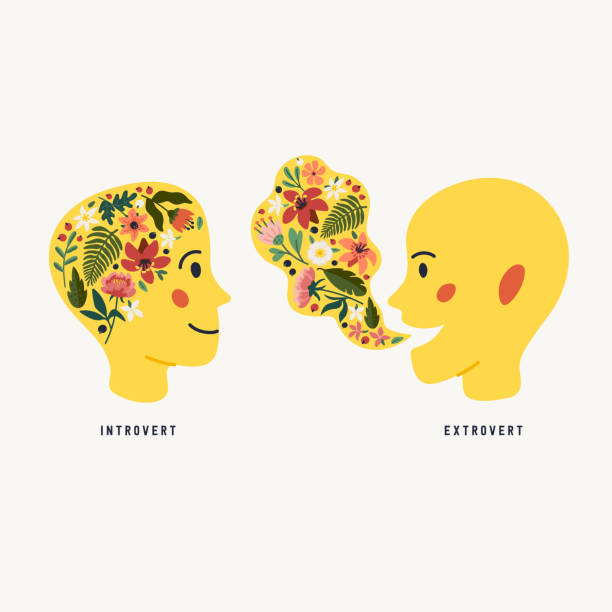

Table of Contents:
- [About the Project](#1)
- [About the Data](#2)
- [Set Up](#3)
- [Exploratory Data Analysis](#4)
    - [Training Data Overview](#4.1)
    - [Testing Data Overview](#4.2)
    - [Target Variable: Personality](#4.3)
    - [Categorical Features](#4.4)
    - [Numeric Features](#4.5)
    - [Interactions](#4.6) 
- [Adversarial Validation](#5)
- [Data Cleaning/Preprocessing](#6)
- [LGBM](#7)
    - [Model Building/Tuning](#7.1)
    - [Model Evaluation](#7.2) 
- [Submission](#8)
- [Conclusion](#c)
- [References](#r)
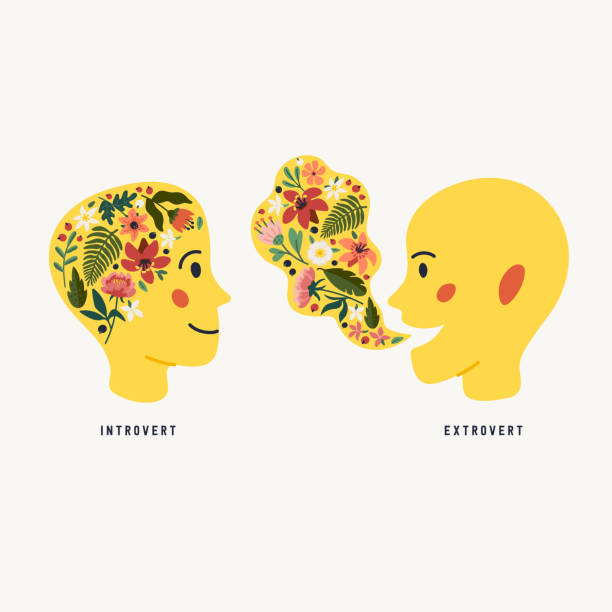

<a id="top"></a>

<a href="#2" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="1"></a>
# **1) About the Project**

---

This project has been completed both as part of Kaggle's competition series and as part of my continued practice and learning of data science techniques. In this particular [Kaggle competition](https://www.kaggle.com/competitions/playground-series-s5e7/overview), we are tasked with predicting whether or not a person is an Introvert or Extrovert, based on their social behavior and personality traits. 

This task poses a binary classification problem, in which a model must correctly determine the correct class (Introvert or Extrovert). The evaluation metric for this project is accuracy score. [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall) is the proportion of all classifications that are correct. 

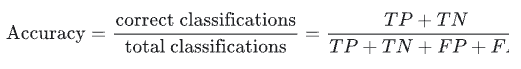

The model used for this project is a [LightGBM](https://github.com/microsoft/LightGBM) model.  LightGBM (LGBM) is a fast, distributed, high performance gradient boosting framework that is based on decision tree algorithms. This type of model is typically effective in classification tasks. LGBM is developed by Microsoft and is publicly available for usage. 

In order to identify the best model parameters, I use [Optuna](https://optuna.org/), which is a hyperparameter optimization framework. Optuna will create and run through 100 trials to determine the ideal hyperparameters for the final LGBM model.

To further boost accuracy, I also use ensemble learning. This is a technique that combines multiple models to improve predictive performance. The final, tuned LGBM model will be combined with XGBoost and CatBoost models. 

I hope you find this project interesting! If you have any questions or suggestions for improvement, please let me know. I am always looking to improve my data skills!

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#3" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="2"></a>
# **2) About the Data**

---

This project utilizes three datasets. Two datasets (training and testing) are provided by Kaggle. These datasets have been generated from a deep learning model trained on the original [Extrovert vs. Introvert Behavior](https://www.kaggle.com/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data/data?select=personality_datasert.csv) dataset. 

Kaggle explicitly states that the feature distributions of the synthetic datasets are 'close to, but not exactly the same' as the original. Because of this, I will be using adversarial validation to determine how similar (or different) the distributions of these datasets are.

**Target Variable:**
- Personality: Extrovert/Introvert

**Numeric Features:**
- id
- Time_spent_Alone
- Social_event_attendance
- Going_outside
- Friends_circle_size
- Post_frequency

**Categorical Features:**
- Stage_fear
- Drained_after_socializing

Both the Kaggle and original datasets are available for public use under the CC BY-SA 4.0 license. 

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#4" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="3"></a>
# **3) Set Up**

---

In [1]:
# Importing and loading necessary libraries and packages

# Fundamental libraries
import pandas as pd
import numpy as np

# Hiding warnings
import warnings
warnings.filterwarnings("ignore")

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = 'white', palette = 'Set2')
pal = sns.color_palette('Set2')

# Scipy stats
from scipy.stats import skew

# Catboost
import catboost
from catboost import Pool, CatBoostClassifier
from catboost.utils import eval_metric

# Sklearn
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.ensemble import VotingClassifier

# LightGBM
import lightgbm
from lightgbm import LGBMClassifier, plot_importance

# Optuna
import optuna
from optuna.samplers import TPESampler

# XGBoost
from xgboost import XGBClassifier

# Tqdm
from tqdm import tqdm

# Shap
import shap
shap.initjs()

In [2]:
# Loading in Kaggle datasets
df_train = pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv", index_col='id')
df_test = pd.read_csv("/kaggle/input/playground-series-s5e7/test.csv", index_col='id')

# Loading in original dataset
df_original = pd.read_csv("/kaggle/input/extrovert-vs-introvert-behavior-data/personality_datasert.csv")

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#5" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="4"></a>
# **4) Exploratory Data Analysis**

---

<a id="top"></a>
<a id="4.1"></a>
## **4.1) Training Data Overview**

In [3]:
# Viewing first 5 entries of 'df_train'
df_train.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [4]:
# Looking at the info of 'df_train'
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           17334 non-null  float64
 1   Stage_fear                 16631 non-null  object 
 2   Social_event_attendance    17344 non-null  float64
 3   Going_outside              17058 non-null  float64
 4   Drained_after_socializing  17375 non-null  object 
 5   Friends_circle_size        17470 non-null  float64
 6   Post_frequency             17260 non-null  float64
 7   Personality                18524 non-null  object 
dtypes: float64(5), object(3)
memory usage: 1.3+ MB


In [5]:
# Creating a function to show a summary of a given dataset
def show_summary(df):
    sum_df = pd.DataFrame(index = list(df))
    sum_df['Dtype'] = df.dtypes
    sum_df['Count'] = df.count()
    sum_df['#Unique'] = df.nunique()
    sum_df['%Unique'] = sum_df['#Unique'] / len(df) * 100
    sum_df['#Null'] = df.isnull().sum()
    sum_df['%Null'] = sum_df['#Null'] / len(df) * 100
    print(sum_df)

In [6]:
# Examining summary of 'df_train'
show_summary(df_train)

                             Dtype  Count  #Unique   %Unique  #Null      %Null
Time_spent_Alone           float64  17334       12  0.064781   1190   6.424098
Stage_fear                  object  16631        2  0.010797   1893  10.219175
Social_event_attendance    float64  17344       11  0.059382   1180   6.370114
Going_outside              float64  17058        8  0.043187   1466   7.914057
Drained_after_socializing   object  17375        2  0.010797   1149   6.202764
Friends_circle_size        float64  17470       16  0.086374   1054   5.689916
Post_frequency             float64  17260       11  0.059382   1264   6.823580
Personality                 object  18524        2  0.010797      0   0.000000


In [7]:
# Examining summary statistics of each numeric column in 'df_train'
df_train.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,3.137764,5.265106,4.044319,7.996737,4.982097
std,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,3.000000,5.000000,3.000000
50%,2.000000,5.000000,4.000000,8.000000,5.000000
75%,4.000000,8.000000,6.000000,12.000000,7.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


### **Observations: 'df_train'**

**Shape of the data**
- 18524 rows, 8 columns (9 including 'id' column)
- 5 numeric columns (float64)
    - Time_spent_Alone
    - Social_event_attendance
    - Going_outside
    - Friends_circle_size
    - Post_frequency 
- 3 categorical columns (object)
    - Stage_fear: Yes/No
    - Drained_after_socializing: Yes/No
    - **Personality** (target variable): Introvert/Extrovert

**Nulls/Missing Values**
- 9196 total null/missing values
    - Time_spent_Alone: 1190 (6.42%)
    - Stage_fear: 1893 (10.22%)
    - Social_event_attendance: 1180 (6.37%)
    - Going_outside: 1466 (7.91%)
    - Drained_after_socializing: 1149 (6.20%)
    - Friends_circle_size: 1054 (5.69%)
    - Post_frequency: 1264 (6.82%)

**Numeric Column Statistics** (Rounded up to 2 decimal points)
- **Time_spent_Alone**
    - Mean: **3.14**; Max: **11.00**; Min: **0.00**
- **Social_event_attendance**
    - Mean: **5.27**; Max: **10.00**; Min: **0.00**
- **Going_outside**
    - Mean: **4.04**; Max: **7.00**; Min: **0.00**
- **Friends_circle_size**
    - Mean: **8.00**; Max: **15.00**; Min: **0.00**
- **Post_frequency**
    - Mean: **4.98**; Max: **10.00**; Min: **0.00**

<a id="top"></a>
<a id="4.2"></a>
## **4.2) Testing Data Overview**

In [8]:
# Viewing first 5 entries of 'df_test'
df_test.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
id,,,,,,,
18524,3.0,No,7.0,4.0,No,6.0,NaN
18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
18526,3.0,No,5.0,6.0,No,15.0,9.0
18527,3.0,No,4.0,4.0,No,5.0,6.0
18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


In [9]:
# Looking at the info of 'df_test'
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6175 entries, 18524 to 24698
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           5750 non-null   float64
 1   Stage_fear                 5577 non-null   object 
 2   Social_event_attendance    5778 non-null   float64
 3   Going_outside              5709 non-null   float64
 4   Drained_after_socializing  5743 non-null   object 
 5   Friends_circle_size        5825 non-null   float64
 6   Post_frequency             5767 non-null   float64
dtypes: float64(5), object(2)
memory usage: 385.9+ KB


In [10]:
# Examining summary of 'df_test'
show_summary(df_test)

                             Dtype  Count  #Unique   %Unique  #Null     %Null
Time_spent_Alone           float64   5750       12  0.194332    425  6.882591
Stage_fear                  object   5577        2  0.032389    598  9.684211
Social_event_attendance    float64   5778       11  0.178138    397  6.429150
Going_outside              float64   5709        8  0.129555    466  7.546559
Drained_after_socializing   object   5743        2  0.032389    432  6.995951
Friends_circle_size        float64   5825       16  0.259109    350  5.668016
Post_frequency             float64   5767       11  0.178138    408  6.607287


In [11]:
# Examining summary statistics of each numeric column in 'df_test'
df_test.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,5750.000000,5778.000000,5709.000000,5825.000000,5767.000000
mean,3.116870,5.287989,4.037835,8.008412,5.028958
std,2.985658,2.758052,2.045207,4.192701,2.867285
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,3.000000,5.000000,3.000000
50%,2.000000,5.000000,4.000000,8.000000,5.000000
75%,4.000000,8.000000,6.000000,12.000000,7.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


### **Observations: 'df_test'**

**Shape of the data**
- 6175 rows, 7 columns (8 including 'id' column)
- 5 numeric columns (float64)
    - Time_spent_Alone
    - Social_event_attendance
    - Going_outside
    - Friends_circle_size
    - Post_frequency 
- 2 categorical columns (object)
    - Stage_fear: Yes/No
    - Drained_after_socializing: Yes/No

**Nulls/Missing Values**
- 3076 total null/missing values
    - Time_spent_Alone: 425 (6.88%)
    - Stage_fear: 598 (9.68%)
    - Social_event_attendance: 397 (6.43%)
    - Going_outside: 466 (7.55%)
    - Drained_after_socializing: 432 (7.00%)
    - Friends_circle_size: 350 (5.67%)
    - Post_frequency: 408 (6.61%)

**Numeric Column Statistics** (Rounded up to 2 decimal points)
- **Time_spent_Alone**
    - Mean: **3.12**; Max: **11.00**; Min: **0.00**
- **Social_event_attendance**
    - Mean: **5.29**; Max: **10.00**; Min: **0.00**
- **Going_outside**
    - Mean: **4.04**; Max: **7.00**; Min: **0.00**
- **Friends_circle_size**
    - Mean: **8.01**; Max: **15.00**; Min: **0.00**
- **Post_frequency**
    - Mean: **5.03**; Max: **10.00**; Min: **0.00**

<a id="top"></a>
<a id="4.3"></a>
## **4.3) Target Variable: Personality**

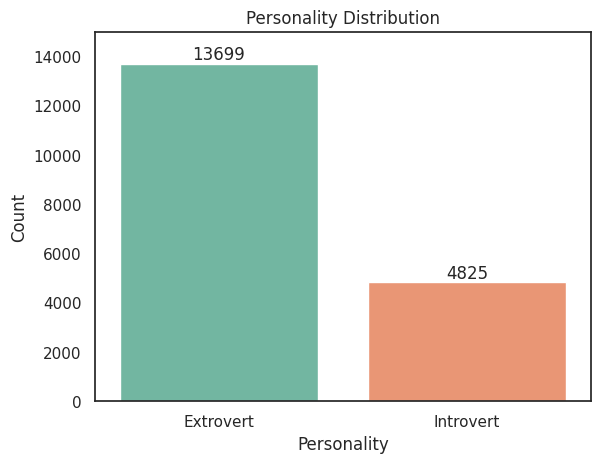

In [12]:
# Creating countplot for target variable 'Personality'
ax = sns.countplot(x='Personality', data=df_train, palette='Set2')
for label in ax.containers:
  ax.bar_label(label)
ax.set_ylabel('Count')
ax.set_xlabel('Personality')
ax.set_title('Personality Distribution')
ax.set_ylim(0, 15000)
plt.show()

In [13]:
# Checking the % proportion of each Personality class
print(df_train['Personality'].value_counts(normalize=True))

Personality
Extrovert    0.739527
Introvert    0.260473
Name: proportion, dtype: float64


### **Observations: 'Personality'**

- Extroverts: 13699 (74%)
- Introverts: 2825 (26%)

From the countplot above, we can see that there is an imbalance of the two classes. The majority (74%) of the training data is made up of Extroverts, with the minority (26%) being Introverts. 

This is a common issue in machine learning and can have a profound negative impact on binary classification models. A model trained on imbalanced data may tend to favor the majority class. 

In the case of this particular project, a resulting model may yield misleadingly high accuracy scores when predicting Extroverts, but may perform worse when predicting Introverts.

Sampling techniques, such as stratified sampling, and model hyperparameter optimization can help reduce the effects of this class imbalance.  

<a id="top"></a>
<a id="4.4"></a>
## **4.4) Categorical Features**

In [14]:
# Creating 'showplot' function to plot categorical features
def showplot(columnname):
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax = ax.flatten()
    value_counts = df_train[columnname].value_counts()
    labels = value_counts.index.tolist()
    colors =["#4caba4", "#d68c78",'#a3a2a2','#ab90a0', '#e6daa3', '#6782a8', '#8ea677']
    
    # Donut Chart
    wedges, texts, autotexts = ax[0].pie(
        value_counts, autopct='%1.1f%%',textprops={'size': 9, 'color': 'white','fontweight':'bold' }, colors=colors,
        wedgeprops=dict(width=0.35),  startangle=80,   pctdistance=0.85  )
    centre_circle = plt.Circle((0, 0), 0.6, fc='white')
    ax[0].add_artist(centre_circle)

    # Count Plot
    sns.countplot(data=df_train, y=columnname, ax=ax[1], palette=colors, order=labels)
    for i, v in enumerate(value_counts):
        ax[1].text(v + 1, i, str(v), color='black',fontsize=10, va='center')
    sns.despine(left=True, bottom=True)
    plt.yticks(fontsize=9,color='black')
    ax[1].set_ylabel(None)
    plt.xlabel("")
    plt.xticks([])
    fig.suptitle(columnname, fontsize=15, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

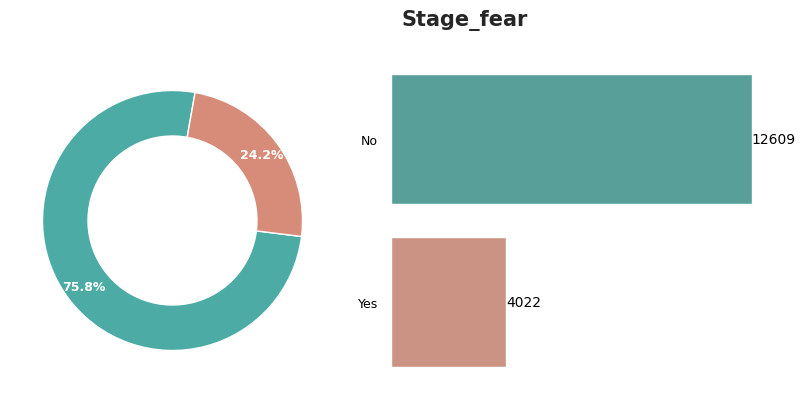

In [15]:
# Using 'showplot' function to visualize 'Stage_fear'
showplot('Stage_fear')

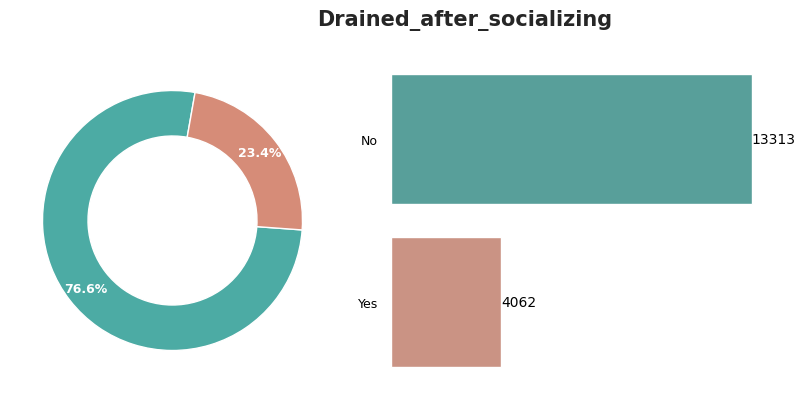

In [16]:
# Using 'showplot function to visualize 'Drained_after_socializing'
showplot('Drained_after_socializing')

### **Observations: Categorical Features**

**Stage fear**
- Yes: 4022 (24.2%)
- No: 12609 (75.8%)

**Drained after socializing**
- Yes: 4062 (23.4%)
- No: 13313 (76.6%)

As with the target variable 'Personality', both of the categorical features 'Stage_fear' and 'Drained_after_socializing' have uneven distributions. The majority (75.8%) of responses for 'Stage_fear' are No, and the majority (76.6%) of responses for 'Drained_after_socializing' are No.

<a id="top"></a>
<a id="4.5"></a>
## **4.5) Numeric Features**

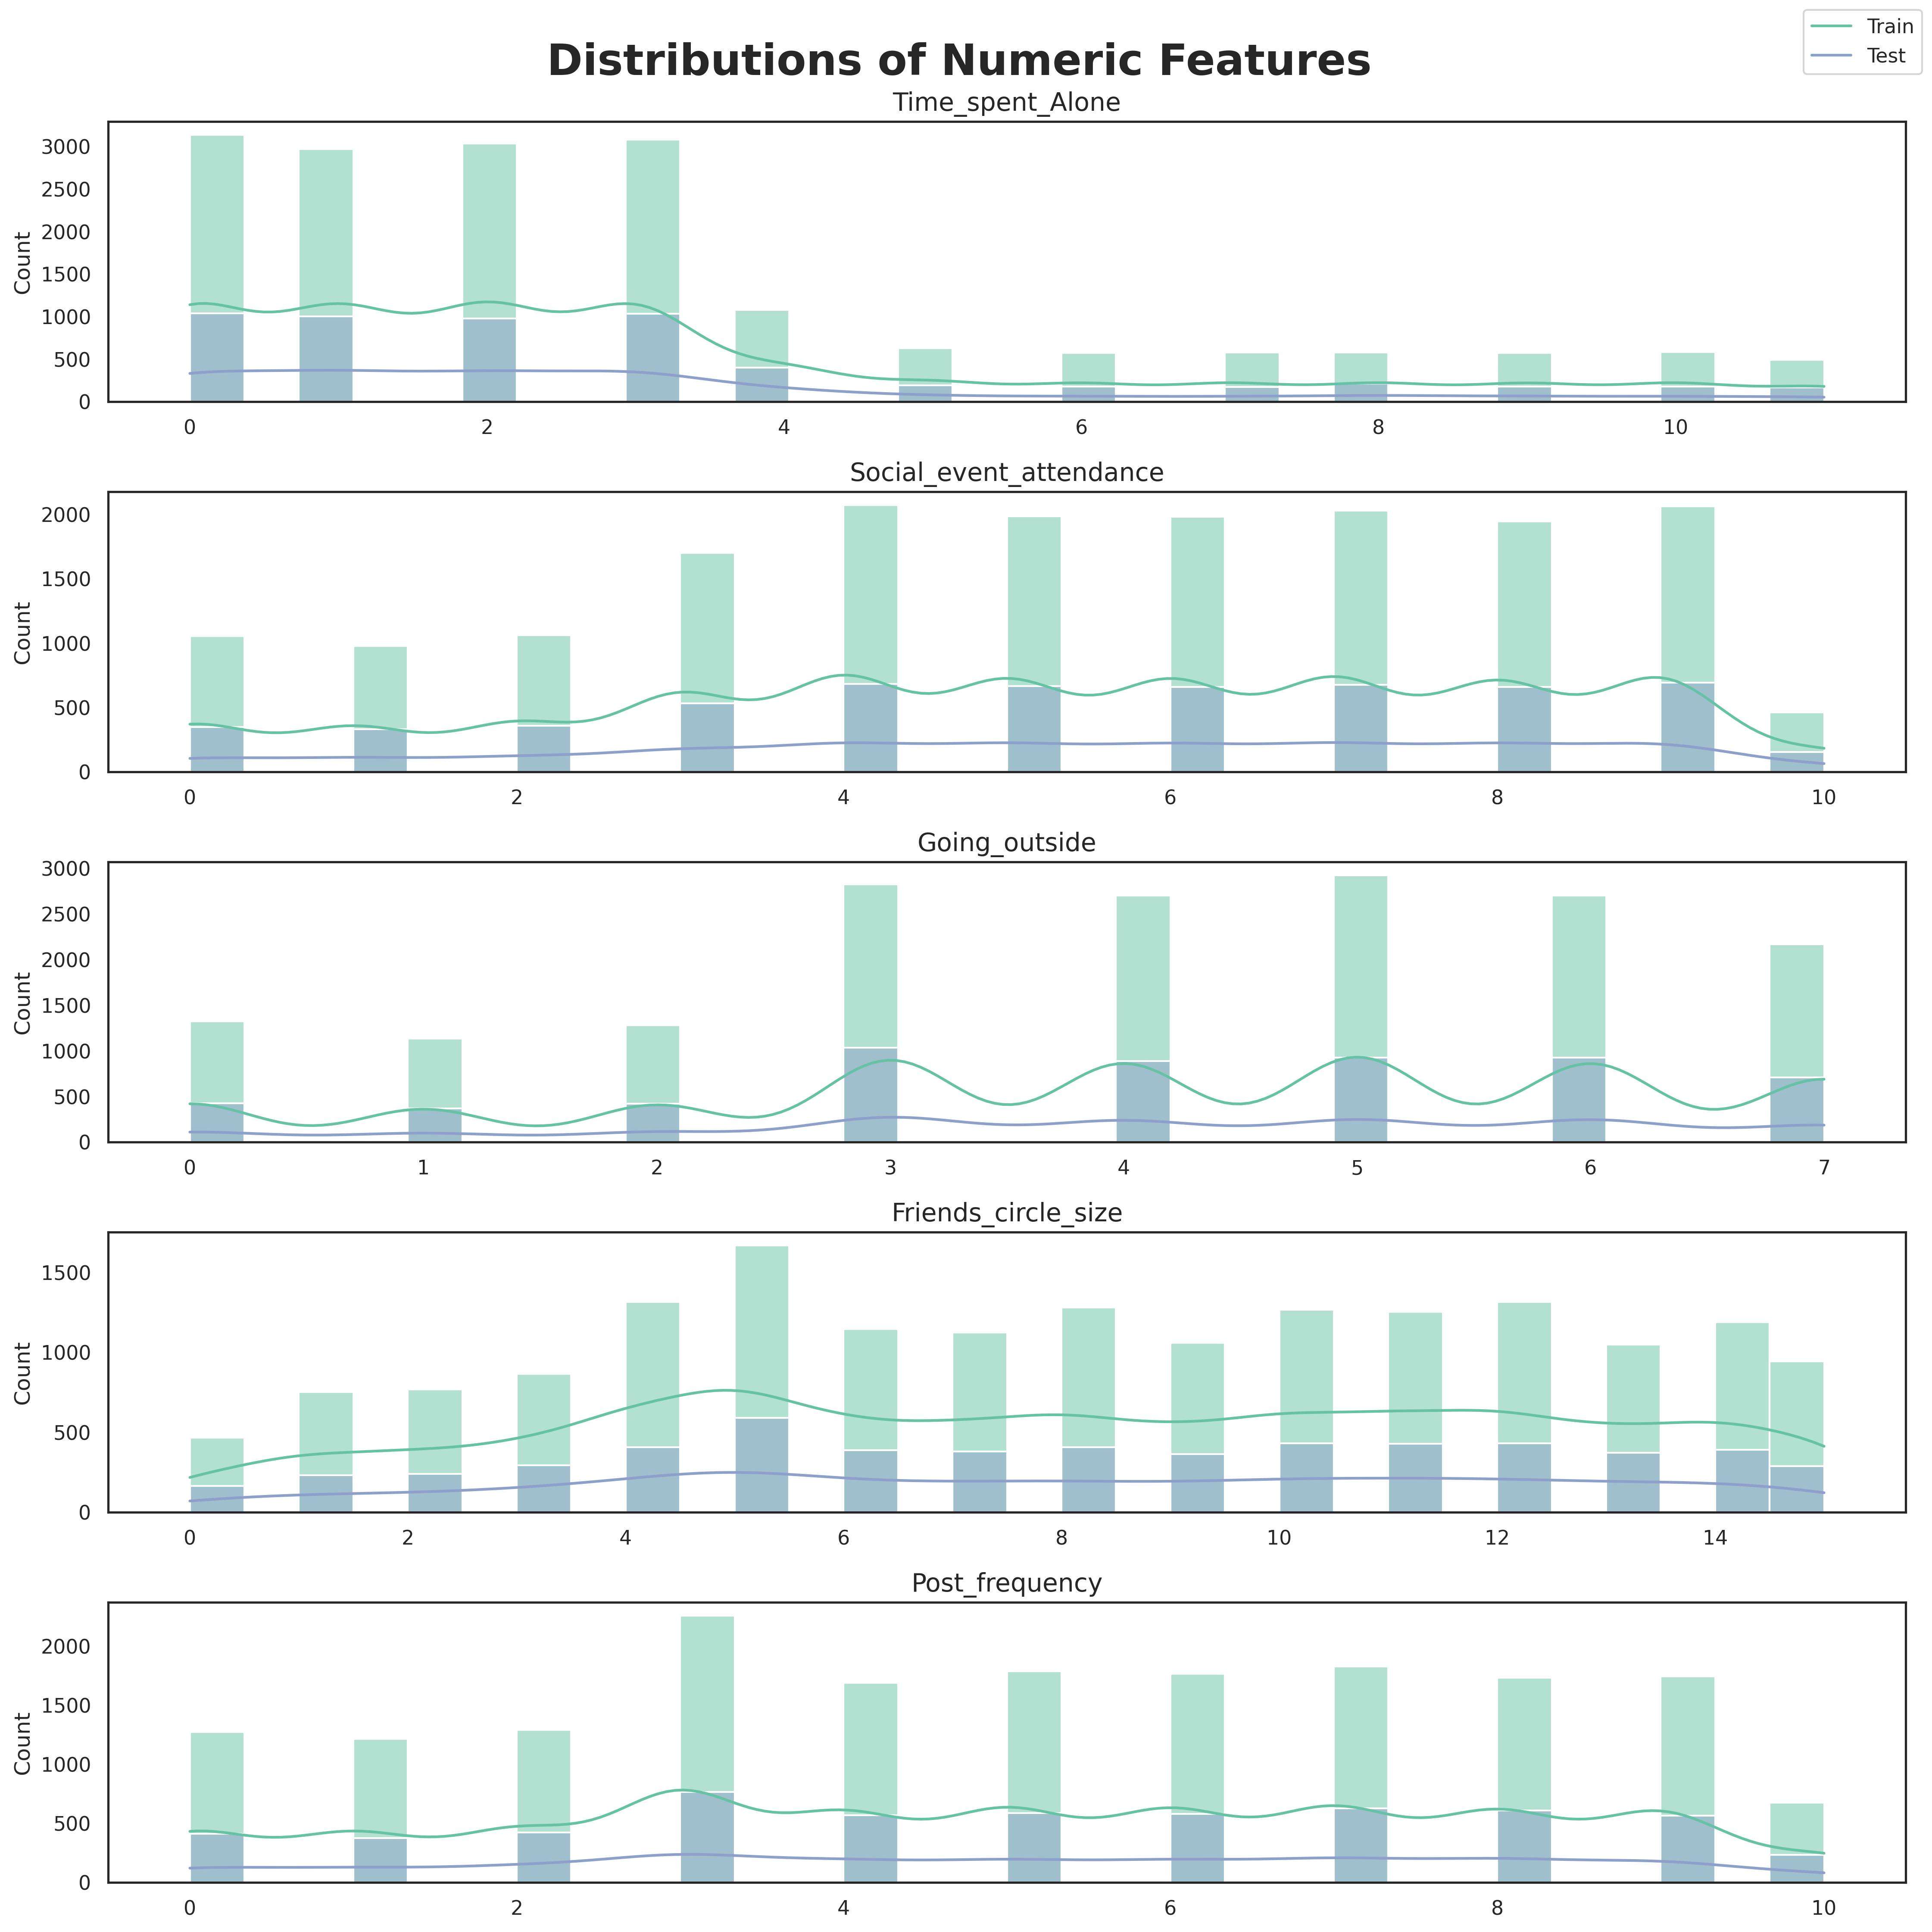

In [17]:
# Visualizing distributions of numeric features (histograms with KDE line)
fig, ax = plt.subplots(5, 1, figsize = (15, 15), dpi = 300)
ax = ax.flatten()
data_numeric = df_train.drop(['Personality', 'Stage_fear', 'Drained_after_socializing'], axis=1)
features = data_numeric.columns

for i, column in enumerate(features):

    sns.histplot(df_train[column], ax=ax[i], color=pal[0], fill=True, kde=True, bins=30)
    sns.histplot(df_test[column], ax=ax[i], color=pal[2], fill=True, kde=True, bins=30)
    ax[i].set_title(f'{column}', size = 14)
    ax[i].set_xlabel(None)

fig.suptitle('Distributions of Numeric Features', fontsize = 24, fontweight = 'bold')
fig.legend(['Train','Test'])
plt.tight_layout()

In [18]:
# Checking skewness of numeric features in 'df_train'
df_train.skew(numeric_only=True)

Time_spent_Alone           1.133777
Social_event_attendance   -0.229238
Going_outside             -0.367221
Friends_circle_size       -0.051806
Post_frequency            -0.058706
dtype: float64

In [19]:
# Checking skewness of numeric features in 'df_test'
df_test.skew(numeric_only=True)

Time_spent_Alone           1.153476
Social_event_attendance   -0.244361
Going_outside             -0.345359
Friends_circle_size       -0.064985
Post_frequency            -0.074961
dtype: float64

### **Observations: Numeric Features**

**Distributions of Numeric Features: Train vs. Test**

The distributions of the numeric features in the train and test datasets appear to be the same. We can confirm this by viewing the similarities of the KDE lines for the train and test sets shown in the histogram above. Furthermore, we can confirm this by comparing the skewness of each feature in the train set to the test set. This is as expected, as the Kaggle train and test sets should have similar distributions. 

**Skewness**

Skewness measures the asymmetry of the distribution of a given feature. If the skew for a given feature is equal to 0, then that feature has a perfectly symmetrical distribution, i.e. values are normally distributed like in a bell curve. If the skew is greater than 0 (positive skew), then that feature has a right-tailed distribution, i.e. more distributed values to the left side of the histogram. Conversely, if the skew is less than 0 (negative skew), then there is a left-tailed distribution, i.e. more distributed values to the right side of the histogram.

'Time_spent_Alone' has a strong positive skew of 1.15. This represents a right-tailed distribution. On the histogram above, we can see that the majority of data is centered around lower values on the x-axis. In other words, we can deduce that most individuals spend less time alone.

'Social_event_attendance' (-0.24) and 'Going_outside' (-0.34) have low to moderate negative skew. This implies somewhat of a left-tailed distribution, with the majority of values being on the higher values of the x-axis. From this, we can postulate that individuals are slightly more likely to spend more time going to social events or outside. 

'Friends_circle_size' (-0.06) and 'Post_frequency' (-0.07) have skews that are close to 0. This implies that both of these features follow a normal distribution. 

<a id="top"></a>
<a id="4.6"></a>
## **4.6) Interactions**

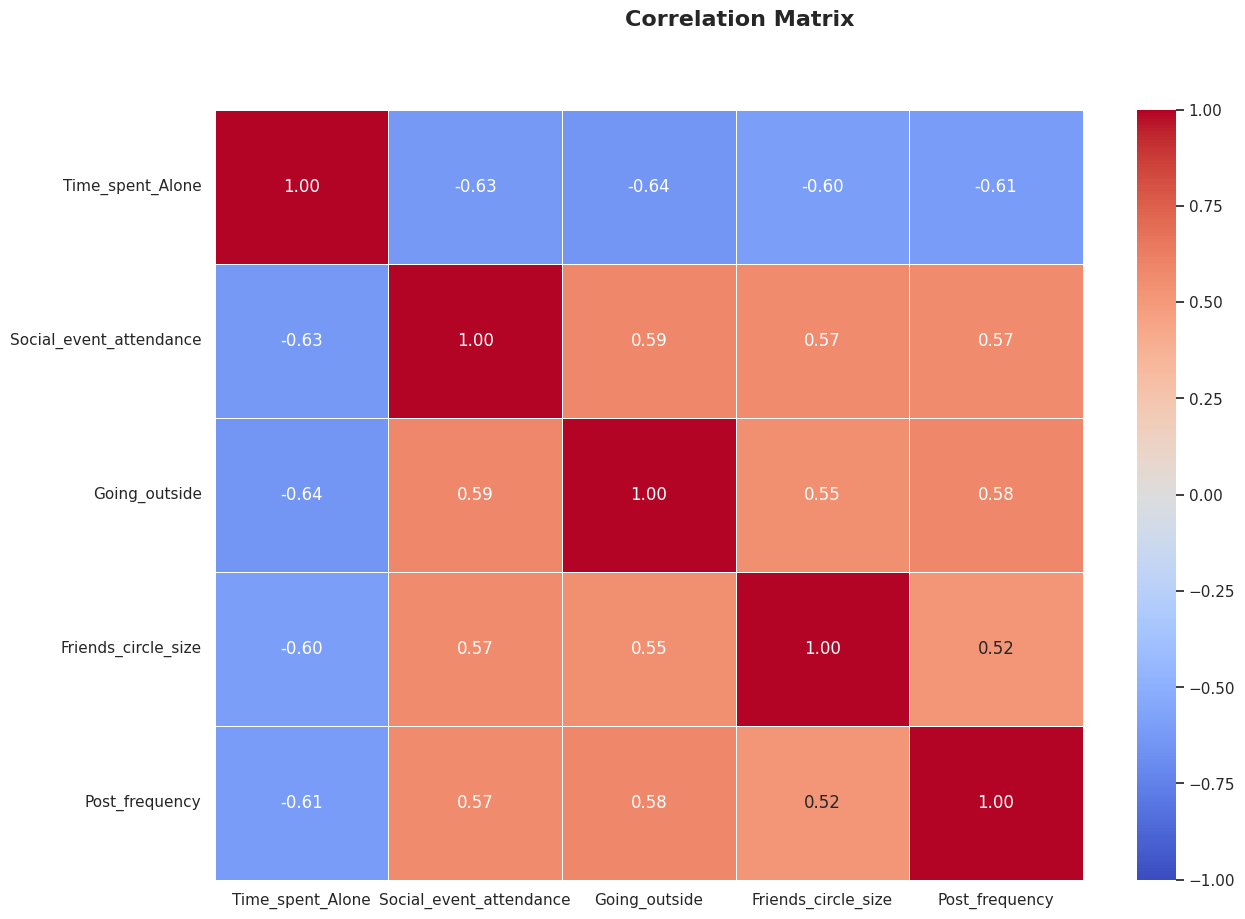

In [20]:
# Visualizing correlation matrix of numeric features in training data
plt.figure(figsize=(14,10))
corr=data_numeric.corr()
sns.heatmap(corr,annot=True,cmap='coolwarm', linewidths=0.5, fmt=',.2f', vmax=1, vmin=-1, center=0)
plt.suptitle('Correlation Matrix', fontsize=16, fontweight='bold')
plt.show()

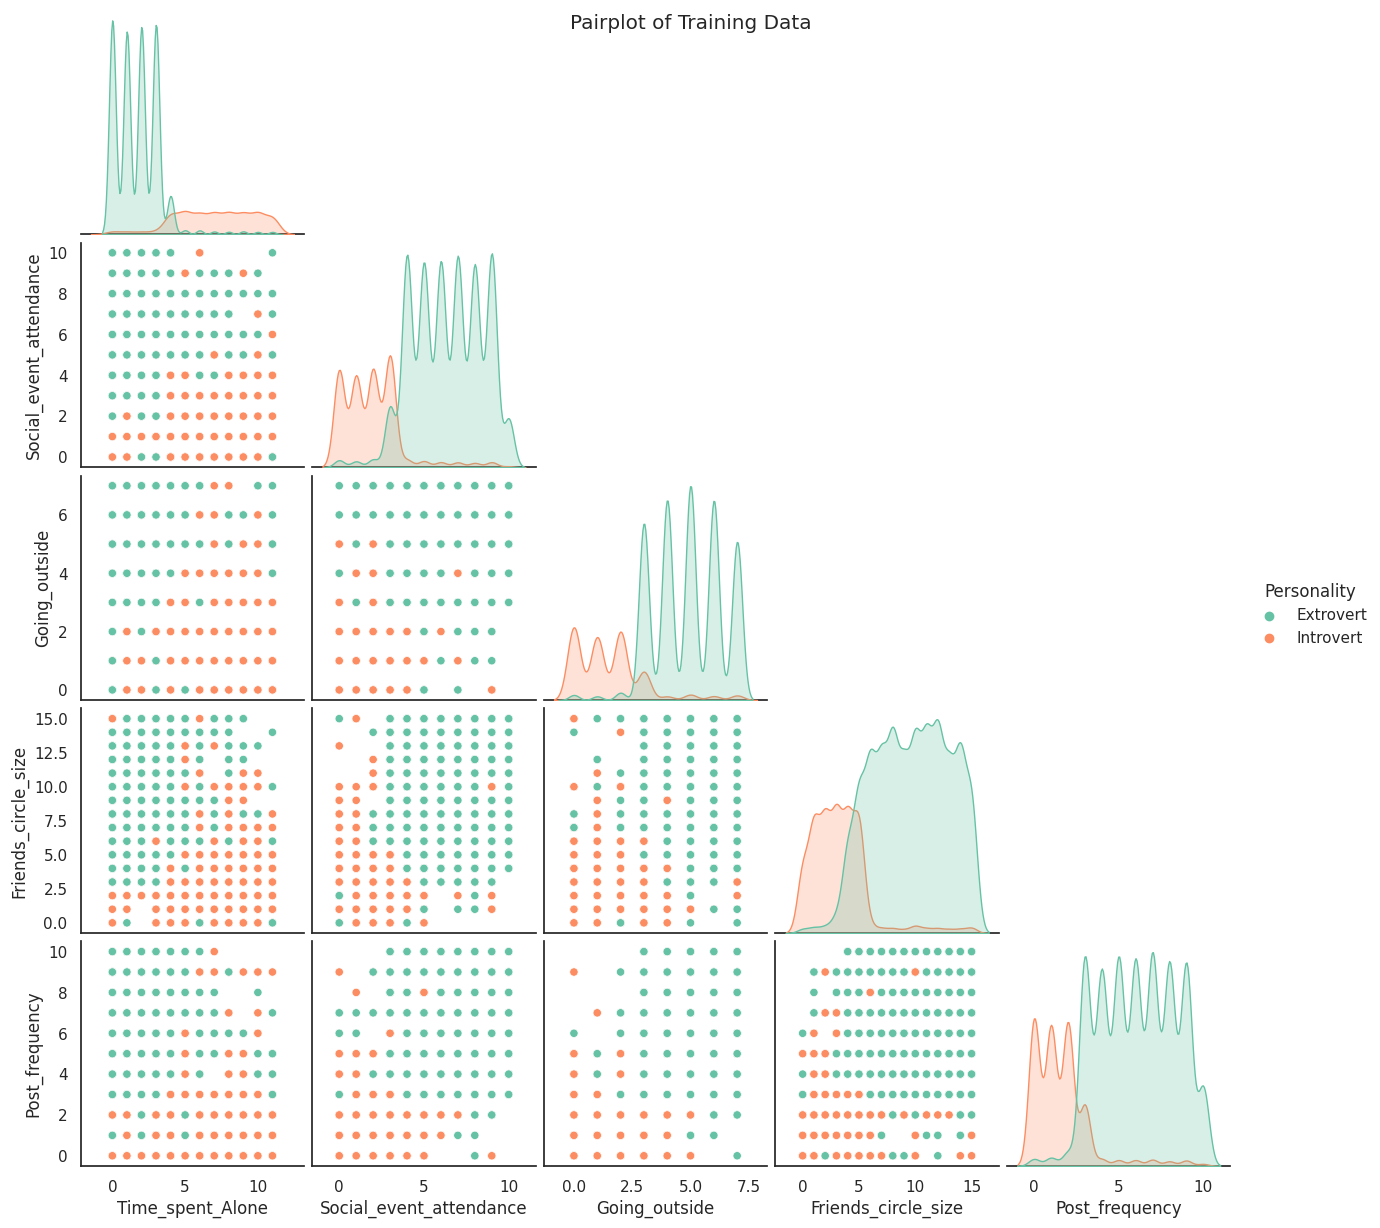

In [21]:
# Visualizing pairplot of 'df_train'
sns.pairplot(df_train.drop(['Stage_fear', 'Drained_after_socializing'], axis=1), hue='Personality', corner=True)
plt.suptitle('Pairplot of Training Data')
plt.show()

### **Observations: Interactions**

**Correlation Matrix**

The correlation matrix above shows the correlations between each numeric feature in the training data. Dark red tones (values close to 1.0) signify a strong positive linear correlation between two features, i.e. as one feature increases in value, so does the other. Dark blue tones (values close to -1.0) signify a strong negative linear correlation, i.e. as one feature increases in value, the other decreases. Correlation values close to 0.0 suggest that there is no linear relationship between the variables. 

As shown in the correlation matrix, each of the cells show a moderate correlation (typically between ±0.4 and ±0.7). 

**Moderate Positive Correlations**
- 'Going_outside' & 'Social_event_attendance': 0.59
- 'Post_frequency' & 'Going_outside': 0.58
- 'Friends_circle_size' & 'Social_event_attendance': 0.57
- 'Post_frequency' & 'Social_event_attendance': 0.57
- 'Friends_circle_size' & 'Going_outside': 0.55
- 'Post_frequency' & 'Friends_circle_size': 0.52

**Moderate Negative Correlations**
- 'Going_outside' & 'Time_spent_alone': -0.64
- 'Social_event_attendance' & 'Time_spent_alone': -0.63
- 'Post_frequency' & 'Time_spent_alone': -0.61
- 'Friends_circle_size' & 'Time_spent_alone': -0.60

**Notable Correlation**
It should be noted that 'Time_spent_alone' has moderate negative correlations with all other numeric features. This suggests that as an individual spends more hours alone, they may likely have fewer friends, spend less time outside and at social events, and post less frequently. Because of this, 'Time_spent_alone' may be a strong predictor in predicting whether someone is an Extrovert or an Introvert.

**Pairplot**

The pairplot above gives us further insight into the relationships between multiple variables. In each individual plot, we can see the relationship between two features (one on the x-axis and one on the y-axis) with the target variable 'Personality' overlaid. The blue data points represent Extroverts and the orange data points represent Introverts. 

**Notable Pairplot**

'Friends_circle_size' & 'Social_event_attendance': Here we can see that Extroverts (blue data points) tend to cluster around higher values of 'Friends_circle_size' and 'Social_event_attendance', while Introverts (orange data points) tend to cluster around lower values. This individual plot shows us that Extroverts tend to have larger friend groups and attend more social events, while Introverts tend to have smaller friend groups and attend less social events. While this is fairly obvious, it is beneficial to utilize pairplots to extract interesting insight from data. 

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#6" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="5"></a>
# **5) Adversarial Validation**

---

In this section, we want to determine whether or not the original data should be combined with the training data provided by Kaggle. As stated by Kaggle, both the train and test sets were generated from a deep learned model trained on the original dataset. HOWEVER, Kaggle also states that the feature distributions are not exactly the same as the original. Thus, incorporating the original data into the training data may negatively impact model performance.

This section will leverage adversarial validation to determine the degree to which the distribution of the original data potentially varies from that of the train data. By combining the two datasets and labeling all train data as 0 and all original data as 1, a simple Catboost classifier will work to distinguish between the datasets. The capability of the classifier will be measured by the AUC on a ROC curve plot. 

If the AUC results are close to 0.5, essentially random guess, that means that the model is unable to determine the difference between the train and original datasets. In this case, we would have sufficient evidence that the two datasets come from the same distribution. However, if the AUC results are close to 1.0, essentially a perfect model, that means the model is easily able to detect a difference between the datasets and thus they are likely from different distributions.

In [22]:
# Dropping null values from 'df_train' and 'df_original'
# Creating temporary dataframes for each: 'df_train_temp' & 'df_original_temp'
df_train_temp = df_train.dropna()
df_original_temp = df_original.dropna()

In [23]:
# Declaring categorical and numerical columns
cat_cols = (['Stage_fear', 'Drained_after_socializing', 'Personality'])
num_cols = (['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
            'Friends_circle_size', 'Post_frequency'])

# Combining categorical and numerical columns into 'features'
features = cat_cols + num_cols

In [24]:
# Creating new target column 'label', where all train set samples are labeled with 0, and all orignal set samples with 1
df_train_temp['label'] = 0
df_original_temp['label'] = 1
target = 'label'

# Combinging 'features' and target 'label' into 'all_cols'
all_cols = features + [target]

In [25]:
# Checking out the shape of 'all_cols' in train and original datasets
df_train_temp[all_cols].shape, df_original_temp[all_cols].shape

((10189, 9), (2900, 9))

In [26]:
# Defining a function to create adversarial data: combines, shuffles, and re-splits the two datasets
# The resulting datasets include a mixture of the train and orignal data
def create_adversarial_data(df_train_temp, df_original_temp, cols, N_val=10000):
    df_master = pd.concat([df_train_temp[cols], df_original_temp[cols]], axis=0)
    adversarial_test = df_master.sample(N_val, replace=False)
    adversarial_train = df_master[~df_master.index.isin(adversarial_test.index)]
    return adversarial_train, adversarial_test

# Applying function to train and orignal data, checking out the resulting shapes
adversarial_train, adversarial_test = create_adversarial_data(df_train_temp, df_original_temp, all_cols)
adversarial_train.shape, adversarial_test.shape

((2504, 9), (10000, 9))

In [27]:
# Setting up the Catboost model for adversarial validation
train_data = Pool(
    data=adversarial_train[features],
    label=adversarial_train[target],
    cat_features=cat_cols
)
holdout_data = Pool(
    data=adversarial_test[features],
    label=adversarial_test[target],
    cat_features=cat_cols
)

# Establishing parameters for the Catboost classifier
params = {
    'iterations': 100,
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'od_wait': 50,
    'random_seed': 42,
    'verbose': 0
}

# Fitting the model to the data
model = CatBoostClassifier(**params)
_ = model.fit(train_data, eval_set=holdout_data)

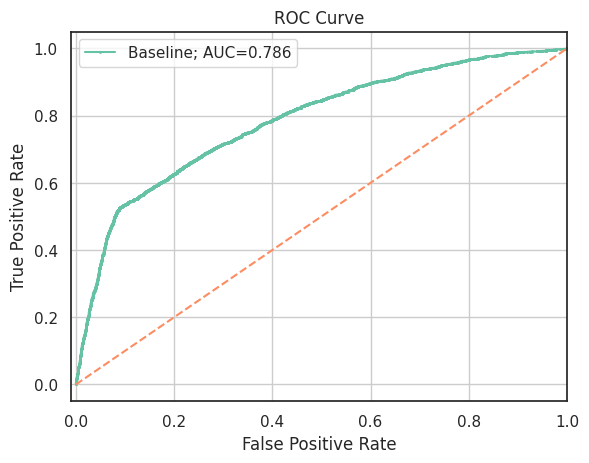

In [28]:
# Setting up ROC Curve plot
def plot_roc(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')
    
# Plotting ROC Curve plot
plot_roc(
    [holdout_data.get_label()],
    [model.predict_proba(holdout_data)[:,1]],
    ['Baseline']
)

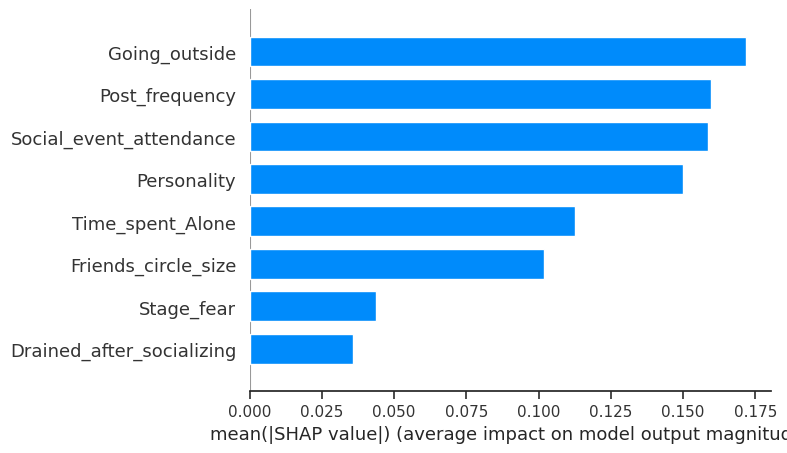

In [29]:
# Defining function to plot feature importance
def plot_importances(model, holdout_data, features):
    shap_values = model.get_feature_importance(holdout_data, type='ShapValues')
    expected_value = shap_values[0,-1]
    shap_values = shap_values[:,:-1]
    shap.summary_plot(shap_values, holdout_data, feature_names=features, plot_type='bar')
    
# Plotting feature importance
plot_importances(model, holdout_data, features)

In [30]:
# Removing 'Post_frequency' and 'Going_outside' and retraining the model
params2 = dict(params)
params2.update({"ignored_features": ['Post_frequency', 'Going_outside']})
model2 = CatBoostClassifier(**params2)
_ = model2.fit(train_data, eval_set=holdout_data, plot=False, verbose=False)

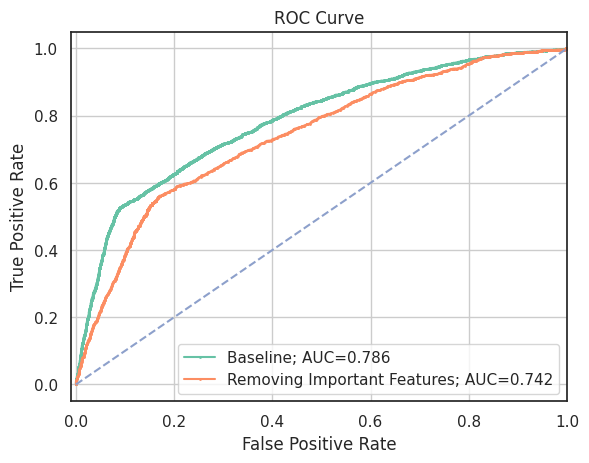

In [31]:
# Plotting updated ROC Curve plot
plot_roc(
    [holdout_data.get_label()]*2,
    [model.predict_proba(holdout_data)[:,1], model2.predict_proba(holdout_data)[:,1]],
    ['Baseline', "Removing Important Features"]
)

### **Observations: Adversarial Validation**

Adversarial validation enables us to determine whether or not two datasets (typically training and testing sets) are from the same distribution. In this case, we wanted to determine whether or not the training data provided by Kaggle follows the same distribution as the original data. The first iteration of the Catboost classifier yielded an AUC of ~0.785 (this may change upon each run of the model). This moderate AUC score signifies that the distributions of the two datasets are meaningfully different. 

By plotting the feature importance of the model, we found that the 'Post_frequency' and 'Going_outside' features were the most impactful on the model. This signifies that these features may be contributing to the difference in distributions between the two datasets. By removing these features and running the model again, the classifier yielded an AUC of ~0.743. While this value shows a slight improvement (it is approaching 0.5), there is still sufficient evidence that the two datasets do not follow the exact same distribution.

In conclusion, the Catboost classifier had moderate success in predicting between the original and Kaggle datasets. In other words, the features in the training data do not come from the exact distribution of the features in the original data. This raises the question as to whether or not to include the original data when training the model. On one hand, using data with a slightly different distribution can make the model more robust at predicting novel data. However, using the original data may also lead to the model making predictions that do not correctly align with the test data.

Due to the results above, I will complete one version of this project without using the original data and one version with the original data to see if its inclusion contributes to better model accuracy. 

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#7" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="6"></a>
# **6) Data Cleaning/Preprocessing**

---

In [32]:
# Reloading in training and testing sets, this time including the 'id' column
df_train = pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s5e7/test.csv")

In [33]:
# Making copies of the training and testing data
df_train_pre = df_train.copy()
df_test_pre = df_test.copy()

In [34]:
# Encoding 'Personality' as 1 (Extrovert) & 0 (Introvert) for training data
df_train_pre['Personality'].replace({'Extrovert': 1, 'Introvert': 0}, inplace=True)

In [35]:
# One-hot encoding categorical variables for training and testing data
df_train_pre = pd.get_dummies(df_train_pre, columns=['Stage_fear', 'Drained_after_socializing'])
df_test_pre = pd.get_dummies(df_test_pre, columns=['Stage_fear', 'Drained_after_socializing'])

In [36]:
# Creating function to impute missing values
def clean_missing_values(df):

    # Imputing median values for numeric columns
    df['Time_spent_Alone'] = df['Time_spent_Alone'].fillna(df['Time_spent_Alone'].median())
    df['Social_event_attendance'] = df['Social_event_attendance'].fillna(df['Social_event_attendance'].median())
    df['Going_outside'] = df['Going_outside'].fillna(df['Going_outside'].median())
    df['Friends_circle_size'] = df['Friends_circle_size'].fillna(df['Friends_circle_size'].median())
    df['Post_frequency'] = df['Post_frequency'].fillna(df['Post_frequency'].median())

# Filling missing values for training and testing sets
clean_missing_values(df_train_pre)
clean_missing_values(df_test_pre)

In [37]:
# Verifying changes made to the training data
df_train_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             18524 non-null  int64  
 1   Time_spent_Alone               18524 non-null  float64
 2   Social_event_attendance        18524 non-null  float64
 3   Going_outside                  18524 non-null  float64
 4   Friends_circle_size            18524 non-null  float64
 5   Post_frequency                 18524 non-null  float64
 6   Personality                    18524 non-null  int64  
 7   Stage_fear_No                  18524 non-null  bool   
 8   Stage_fear_Yes                 18524 non-null  bool   
 9   Drained_after_socializing_No   18524 non-null  bool   
 10  Drained_after_socializing_Yes  18524 non-null  bool   
dtypes: bool(4), float64(5), int64(2)
memory usage: 1.1 MB


In [38]:
# Verifying changes made to the testing data
df_test_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             6175 non-null   int64  
 1   Time_spent_Alone               6175 non-null   float64
 2   Social_event_attendance        6175 non-null   float64
 3   Going_outside                  6175 non-null   float64
 4   Friends_circle_size            6175 non-null   float64
 5   Post_frequency                 6175 non-null   float64
 6   Stage_fear_No                  6175 non-null   bool   
 7   Stage_fear_Yes                 6175 non-null   bool   
 8   Drained_after_socializing_No   6175 non-null   bool   
 9   Drained_after_socializing_Yes  6175 non-null   bool   
dtypes: bool(4), float64(5), int64(1)
memory usage: 313.7 KB


In [39]:
# Steps taken IF including the original dataset
run = 0

if run == 1:
    # Reading in a clean version of the original dataset
    df_original = pd.read_csv("/kaggle/input/extrovert-vs-introvert-behavior-data/personality_datasert.csv")

    # Applying encoding steps to the original dataset
    df_original['Personality'].replace({'Extrovert': 1, 'Introvert': 0}, inplace=True)
    df_original = pd.get_dummies(df_original, columns=['Stage_fear', 'Drained_after_socializing'])

    # Combining training data and original data
    df_combined = pd.concat([df_train_pre, df_original], axis=0, ignore_index=True)

    # Creating final versions of each cleaned dataset
    train = df_combined.copy()
    test = df_test_pre.copy()

In [40]:
# Steps taken IF NOT including the original dataset

run = 1

if run == 1:
    # Creating final versions of each cleaned dataset (NOT INCLUDING ORIGINAL)
    train = df_train_pre.copy()
    test = df_test_pre.copy()

### **Data Cleaning/Preprocessing Summary**

- Created copies of fresh data for cleaning
- Encoded target variable 'Personality': 1 (Extrovert), 0 (Introvert)
- Applied one-hot encoding to 'Stage_fear' and 'Drained_after_socializing' 
- Filled null/missing values with median values for numeric columns
- Created copies of cleaned data, ready for model use
- Created an optional path to include original data

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#8" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="7"></a>
# **7) LGBM**

---

<a id="top"></a>
<a id="7.1"></a>
## **7.1) Model Building/Tuning**

### **Predetermined Parameters**
- **'objective': 'binary'** --> the objective parameter is set to binary, as this is a binary classification problem
- **'verbosity': -1** --> this lowers the verbosity (amount of text generated) of the LightGBM model
- **'boosting_type': 'gbdt'** --> this sets the boosting type to traditional gradient boosting decision tree
- **'random_state': 42** --> this sets a random state which can be used for reproducing specific results

### **Parameters Needing to be Optimized**
- **'num_leaves'** --> this controls the maximum number of leaves in each tree, higher values create more complex trees but may overfit, lower values create simpler tree but may underfit
- **'learning_rate'** --> the shrinkage rate, a smaller learning rate may improve accuracy but will also slow training
- **'n_estimators'** --> essentially the number of boosting iterations
- **'subsample_for_bin'** --> the number of data sampled to construct feature discrete bins, larger values may give better results
- **'reg_alpha' & 'reg_lambda'** --> aliases for lambda_l1 & lambda_l2, L1 & L2 regularization
- **'max_depth'** --> this limits the max depth of the tree model, deeper trees can capture more complex patterns but may also overfit
- **'colsample_bytree'** --> this helps speed up training and potentially deal with over-fitting
- **'subsample'** --> similar to "colsample_bytree" but randomly selects part of the data without resampling, can also be used to speed up training
- **'min_child_samples'** --> the minimal number of data in one tree leaf, helps with over-fitting
- **'feature_fraction'** --> the fraction of features used to train the decision tree, can help with over-fitting
- **'bagging_fraction'** --> similar to feature fraction, can help speed up training and reduce over-fitting


In [41]:
# Calculating weight for positive/negative classes
Introvert = (train['Personality'] == 0).sum()
Extrovert = (train['Personality'] == 1).sum()
scale_pos_weight = Introvert / Extrovert
print(f"scale_pos_weight: {scale_pos_weight:.4f}")

scale_pos_weight: 0.3522


In [42]:
# Setting up training and testing sets for the model
ID = test['id']
X_train = train.drop(['Personality', 'id'], axis=1)
y_train = train['Personality']
X_test = test.drop(['id'], axis=1)

In [43]:
# Defining the Optuna trial which will work to tune the parameters of the LGBM model

# Creating the objective for optuna
def objective(trial):

    imbalance_strategy = trial.suggest_categorical("imbalance_strategy", ["scale_pos_weight", "is_unbalance"])
    
    params = {
        'objective': 'binary',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1200),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0)
    }

    # Applying imbalance handling
    if imbalance_strategy == "scale_pos_weight":
        params['scale_pos_weight'] = scale_pos_weight
    else:
        params['is_unbalance'] = True
    
    # Fitting LGBM model with parameters from the trials
    model = LGBMClassifier(**params)
    # Stratified sampling 
    cv = StratifiedKFold(5, shuffle=True, random_state=42)
    cv_splits = cv.split(X_train, y_train)
    
    # Creating empty scores list to hold AUC scores from each trialed model
    scores = []
    for train_idx, val_idx in cv_splits:
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_train_fold, y_train_fold)
        y_pred_acc = model.predict(X_val_fold)
        score = accuracy_score(y_val_fold, y_pred_acc)
        scores.append(score)
    
    # Printing and returning mean AUC scores
    mean_score = np.mean(scores)
    print(f"Mean Accuracy Score = {mean_score:.5f}")
    return mean_score

# When set to 1, optuna will create a study to find the optimal parameters
run = 0

if run == 1:
    
    # Each optuna study uses an independent sampler with a TPE algorithm
    # For each trial, the TPE essentially uses Gaussian Mixture Models to identify the optimal parameter value
    study = optuna.create_study(sampler=TPESampler(n_startup_trials=30, multivariate=True, seed=42), direction="maximize")
    study.optimize(objective, n_trials=100)
    print('Best value:', study.best_value)
    print('Best trial:', study.best_trial.params)

In [44]:
# Recording best parameters from trial (changed hyperparameter suggested values)
best_params = {'objective': 'binary',
               'verbosity': -1,
               'boosting_type': 'gbdt',
               'random_state': 42,
               'num_leaves': 259, 
               'learning_rate': 0.029385442161128397, 
               'n_estimators': 369, 
               'subsample_for_bin': 175904, 
               'reg_alpha': 2.2990464275110867, 
               'reg_lambda': 0.009126367790369154, 
               'max_depth': 8, 
               'colsample_bytree': 0.368023545639538, 
               'subsample': 0.7112554200243772, 
               'min_child_samples': 100, 
               'feature_fraction': 0.570042007618262, 
               'bagging_fraction': 0.7591648261818684}

In [45]:
# Recording best parameters from trial (added an imbalance strategy)
best_params_2 = {'objective': 'binary',
                 'verbosity': -1,
                 'boosting_type': 'gbdt',
                 'random_state': 42,
                 'imbalance_strategy': 'is_unbalance', 
                 'num_leaves': 54, 
                 'learning_rate': 0.014279602588224386, 
                 'n_estimators': 225, 
                 'subsample_for_bin': 274214, 
                 'reg_alpha': 0.0032476530557493336, 
                 'reg_lambda': 1.8189460933139643e-08, 
                 'max_depth': 10, 
                 'colsample_bytree': 0.6049618875191283, 
                 'subsample': 0.9441173058325185, 
                 'min_child_samples': 60, 
                 'feature_fraction': 0.6413167361944319, 
                 'bagging_fraction': 0.7624510407122069}

In [46]:
# Recording best parameters (includes imbalance strategy & one-hot encoded categorical variables)
best_params_3 = {'verbosity': -1,
                 'imbalance_strategy': 'scale_pos_weight', 
                 'num_leaves': 38, 
                 'learning_rate': 0.018360371052560654, 
                 'n_estimators': 401, 
                 'subsample_for_bin': 98381, 
                 'reg_alpha': 0.01773808344715304, 
                 'reg_lambda': 4.447246083105632, 
                 'max_depth': 6, 
                 'colsample_bytree': 0.7984469645792099, 
                 'subsample': 0.8538489583255215, 
                 'min_child_samples': 52, 
                 'feature_fraction': 0.7047879681680635, 
                 'bagging_fraction': 0.7107751393073273}

In [47]:
# Fitting the model with the best parameters!
final_model = LGBMClassifier(**best_params_3)
final_model.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=0.7107751393073273,
               colsample_bytree=0.7984469645792099,
               feature_fraction=0.7047879681680635,
               imbalance_strategy='scale_pos_weight',
               learning_rate=0.018360371052560654, max_depth=6,
               min_child_samples=52, n_estimators=401, num_leaves=38,
               reg_alpha=0.01773808344715304, reg_lambda=4.447246083105632,
               subsample=0.8538489583255215, subsample_for_bin=98381,
               verbosity=-1)

<a id="top"></a>
<a id="7.2"></a>
## **7.2) Model Evaluation**

In [48]:
# Obtaining final mean accuracy score, using stratified sampling again
cv = StratifiedKFold(5, shuffle=True, random_state=42)
cv_splits = tqdm(cv.split(X_train, y_train), total=cv.get_n_splits(), desc='CV Progress')

scores = []
for train_idx, val_idx in cv_splits:
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    final_model.fit(X_train_fold, y_train_fold)
    y_pred = final_model.predict(X_val_fold)
    score = accuracy_score(y_val_fold, y_pred)
    scores.append(score)
    
    print(f'score: {score:.5f}')

print(f"Mean Score ＝ {np.mean(scores):.5f}") 

CV Progress:  20%|██        | 1/5 [00:00<00:01,  2.01it/s]

score: 0.96977


CV Progress:  40%|████      | 2/5 [00:00<00:01,  2.04it/s]

score: 0.96761


CV Progress:  60%|██████    | 3/5 [00:01<00:00,  2.02it/s]

score: 0.96626


CV Progress:  80%|████████  | 4/5 [00:01<00:00,  2.01it/s]

score: 0.97004


CV Progress: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

score: 0.97138
Mean Score ＝ 0.96901


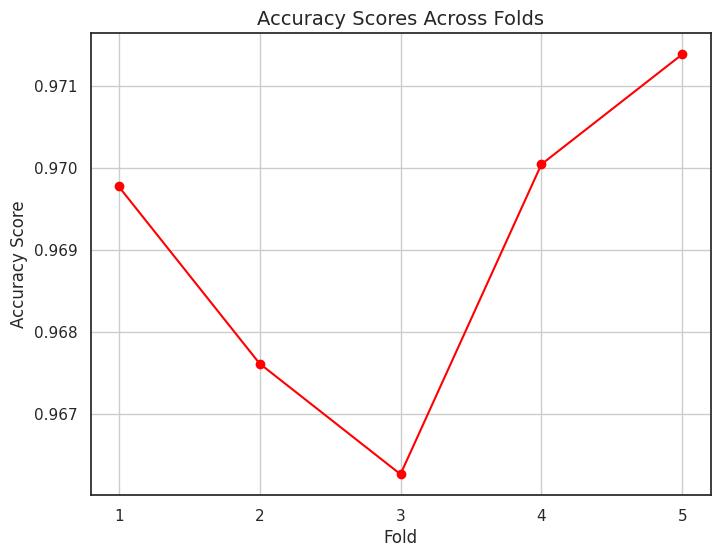

In [49]:
# Visualizing accuracy scores across folds
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(scores) + 1), scores, marker='o', linestyle='-', color='r')
plt.title("Accuracy Scores Across Folds", fontsize=14)
plt.xlabel("Fold", fontsize=12)
plt.ylabel("Accuracy Score", fontsize=12)
plt.grid(True)
plt.xticks(range(1, len(scores) + 1))
plt.show()

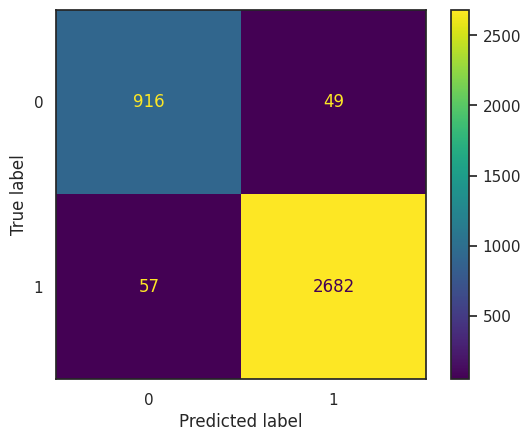

In [50]:
# Viewing confusion matrix, predictions compared to validation data
y_pred = final_model.predict(X_val_fold)
cm = confusion_matrix(y_val_fold, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

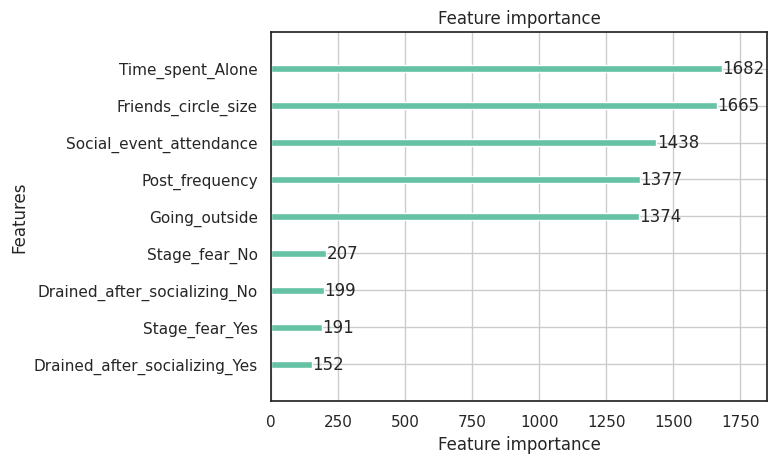

In [51]:
# Viewing feature importance for the final model
plot_importance(final_model)

<a id="top"></a>
<a id="7.3"></a>
## **7.3) Ensemble**

In [52]:
# This ensemble setup has been adapted from a great work by H-Z-NING (linked in the references section)

# Splitting 'train' dataset into features (X) and target (y)
X = train.drop(['Personality', 'id'], axis=1)
y = train['Personality']
# Splitting data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Setting up ensemble of models (XGBoost, CatBoost, LGBM)
xgb = XGBClassifier(
    max_depth=4,         
    learning_rate=0.01,   
    n_estimators=1000,    
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42)

cat = CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.1,
    class_weights=[scale_pos_weight, 1],
    random_seed=42,
    verbose=0)

lgbm = LGBMClassifier(**best_params_3)

# Creating ensemble
ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb),
        ('cat', cat),
        ('lgbm', lgbm)],
    voting='soft')

# Fitting ensemble model to training data
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                             colsample_bytree=0.7984469645792099,
                                             feature_fraction=0.7047879681680635,
                                             imbalance_strategy='scale_pos_weight',
                                             learning_rate=0.018360371052560654,
                                             max_depth=6, min_child_samples=52,
                                             n_estimators=401, num_leaves=38,
                                             reg_alpha=0.01773808344715304,
                                             reg_lambda=4.447246083105632,
                                             subsample=0.8538489583255215,
                                             subsample_for_bin=98381,
                                             verbosity=-1))],
                 voting='soft')

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a href="#c" style="background-color:blue; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Next Section</a><a id="top"></a>

<a id="8"></a>
# **8) Submission**

---

In [53]:
# Optimizing prediction threshold
val_probs = ensemble.predict_proba(X_valid)[:, 1]
best_threshold = 0.5
best_acc = 0

for threshold in np.arange(0.4, 0.6, 0.01):
    preds = (val_probs >= threshold).astype(int)

In [54]:
# Making prediction probabilities on the test data, using the final ensemble model
probs = ensemble.predict_proba(X_test)[:, 1]

# Converting probabilities to predictions
predictions = (probs >= best_threshold).astype(int)

# Creating submission with model predictions
submission = pd.DataFrame({'id': ID, "Personality": predictions})

# Converting 1s back to Extrovert and 0s back to Introvert
submission['Personality'].replace({1: 'Extrovert', 0: 'Introvert'}, inplace=True)

In [55]:
# Creating .csv file for submissions and scoring
run = 1

if run == 1:
    submission.to_csv('submission.csv', index=False)

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a id="c"></a>
# **Conclusion**

---

### **Final Model Performance: LGBM**

Across folds the best accuracy score of the final LGBM model was 0.97138 and the mean accuracy score was 0.96901. 

In terms of feature importance, 'Time_spent_alone' was the most impactful feature on the model, followed closely by 'Friends_circle_size'. 

### **Ensemble Performance**

By combining the tuned LGBM model with XGBoost and CatBoost models, I was able to achieve higher accuracy. In terms of competition scoring, the ensemble model yielded an accuracy of 97.4089% (public score). 

### **Considerations**

There are typically many ways to improve model performance. To start, future work could try different methods of imputation (such as with KNN) to resolve the null values found in the training and testing datasets. Conversely, it might even be beneficial to keep the nulls present in the data, as many advanced models can handle the missing data.

Furthermore, the data preprocessing steps could include feature engineering. New features, such as the ratio of 'Friends_circle_size' to 'Post_frequency' could be created and may possibly contribute to a better model.

In terms of the LGBM model itself, the Optuna trials could be run again with different suggestions for each hyperparameter.

Other decision tree models, such as XGBoost, could be used to see if they perform better than LGBM on this particular dataset.

Lastly, different models, such as logistic regression, could be included in the ensemble learning. This may provide better predictions and thus a higher accuracy score. 

### **Thank you!**

Thank you again for taking the time to view my project. Again, please feel free to leave a comment if you have any questions or suggestions for this work.

If you are interested, please check out some of my other works!
- Rainfall Prediction: https://www.kaggle.com/code/conradkleykamp/rainfall-prediction-xgboost
- Loan Approval Prediction: https://www.kaggle.com/code/conradkleykamp/loan-approval-prediction-lgbm-w-optuna

<a id="top"></a>

<a href="#top" style="background-color:green; color:white; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="top"></a>

<a id="r"></a>
# **References**

---

- Kaggle competition: https://www.kaggle.com/competitions/playground-series-s5e7/overview
- Accuracy: https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall
- LightGBM: https://github.com/microsoft/LightGBM
- Optuna: https://optuna.org/
- Extrovert vs. Introvert Behavior Data: https://www.kaggle.com/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data/data?select=personality_datasert.csv
- H-Z-NING: https://www.kaggle.com/code/hzning/top-3-solution-0-976518-easy-is-all-you-need/notebook#Model-Training